# Cars4U Project

# 1. Introduction

 The price of used cars depends on many factors. As there are uncertainities in the price of the used car, leveraging a model  to predict the price of the used cars is imperative to help the business understand how exactly the prices vary with the independent variables. Business can accordingly devise profitable strategies to meet certain price levels.

 In this notebook, I am using linear regression model to predict the price of the users cars, which is simple and suitable for the data set. The dataset contains various independent variables such as `year`, `model`, `engines` etc. that are being analyzed. The data was trained by the model and cross-validated for accuracy of trained and test set using Mean Absolute Error
 
## Problem:

**The dataset aims to answer the following key questions:**

* Does various independent variables really affect the Price?
* What are the independent variables actually affecting the Price?
* Does increase in the power of cars increase the value of cars?
* Does engine and fuel type have any correlation to the prices?
* Does any specific fuel type increase the price of cars?
- Does mileage affect the price for any specific fuel type?
- What is the price dispersion with year model and transmission and fuel type?


Analysis covered in this notebook are as follows:

* Load, explore and visualize the data
* Data pre-processing
* Data exploratory analysis - univariate and bivariate analysis
* Data preparation - outlier treatment
* Build linear regression model to predict the price of used cars and check the MAE
* Model performance evaluation
* Insights and recommendations

## Data Dictionary:

* S.No. : Serial Number
* Name : Name of the car which includes Brand name and Model name
* Location : The location in which the car is being sold or is available for purchase Cities
* Year : Manufacturing year of the car
* Kilometers_driven : The total kilometers driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner : Type of ownership
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model in INR Lakhs.(1 Lakh = 100, 000)
* Price : The price of the used car in INR Lakhs (1 Lakh = 100, 000)

# 2. Loading libraries

In [523]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
sns.set(color_codes = True)
sns.set_style('darkgrid')
import warnings
import re
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.1f' % x) # To supress numerical display in scientific notations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
# To create linear regression model
from sklearn.linear_model import LinearRegression

# To check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 3. Loading and exploring the data
In this section the goals are to load the data into dataframe and check its basic properties. This will include the dimension, column types and names, and missingness counts.

In [524]:
data = pd.read_csv('used_cars_data.csv')
df = data.copy() # copying to a another dataframe to keep the original dataframe intact to refer back

In [525]:
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.8
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.5
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.5
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.0
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.7


The column `Price` is the target variable and rest of the columns are independent variables. From the random 5 rows there are no major issues with missing values except the `new_price`. Some of the variables such as mileage, engine, power etc have text values which can be removed. Also, the car name contains both the brand name and the model which can be split for meaningful analysis

In [526]:
df.shape

(7253, 14)

There are 7253 rows and 14 columns

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


`New_price` is of object type, we want it to be numeric. It appears that the values include the currency text hence that data is in string format.`Mileage`, `Engine` and `Power` are represented as strings, we need to convert it to numeric fields. `Seats` need not be of float type. This can be converted to int. I also observered missing values by looking at the 10 random rows of the data. We need to analyze that in the later sections

In [528]:
df.drop(['S.No.'],axis=1,inplace=True)

It does n't seem like `S.No.` is relevant for the analysis. Hence we can drop this feature

# 4. Data Pre-processing

Since majority of the columns are of object type. we need to process and convert them to numeric before we can do data exploratory analysis. Lets process the columns one by one. It looks like there are 6 columns with missing values

In [529]:
# looking at which columns have the most missing values
df.isnull().sum().sort_values(ascending=False)

New_Price            6247
Price                1234
Seats                  53
Power                  46
Engine                 46
Mileage                 2
Owner_Type              0
Transmission            0
Fuel_Type               0
Kilometers_Driven       0
Year                    0
Location                0
Name                    0
dtype: int64

### 4.1 Processing `Name` Column
Name contains both the brand name and model name. Need to modify the 'Name' of the car and extract brand name and model name as separate columns

In [530]:
#Splitting company name from CarName column
carname = df["Name"].str.split(" ", n = 1, expand = True)
# name columns is now split into 2 separate columns with brand name and model name
df.drop(['Name'], axis=1, inplace=True)
df["Model"]= carname[1]   
df["Brand"]= carname[0]

In [531]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Model,Brand
0,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.8,Wagon R LXI CNG,Maruti
1,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.5,Creta 1.6 CRDi SX Option,Hyundai
2,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.5,Jazz V,Honda
3,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.0,Ertiga VDI,Maruti
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.7,A4 New 2.0 TDI Multitronic,Audi


In [532]:
df['Brand'].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'BMW', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Smart', 'Ambassador', 'Isuzu', 'ISUZU', 'Force', 'Bentley',
       'Lamborghini', 'Hindustan', 'OpelCorsa'], dtype=object)

I noticed there are few duplicate names in `Brand`. Also, the split function cut off the full name, for example "Land Rover". We need to fix these issues and standardize the brand names

In [533]:
df.Brand = df.Brand.str.lower()
def replace_name(a,b):
    df.Brand.replace(a,b,inplace=True)
replace_name('land','land rover')
replace_name('opelcorsa','opel')

After using the replace function, now the brand names appear clean

In [534]:
df['Brand'].unique()

array(['maruti', 'hyundai', 'honda', 'audi', 'nissan', 'toyota',
       'volkswagen', 'tata', 'land rover', 'mitsubishi', 'renault',
       'mercedes-benz', 'bmw', 'mahindra', 'ford', 'porsche', 'datsun',
       'jaguar', 'volvo', 'chevrolet', 'skoda', 'mini', 'fiat', 'jeep',
       'smart', 'ambassador', 'isuzu', 'force', 'bentley', 'lamborghini',
       'hindustan', 'opel'], dtype=object)

### 4.2 Missing value treatment for `Mileage`
There are 2 missing values for Mileage. Before converting it to numeric, we need to first fill the missing values. I notice that some of the values are in km/kg and some are in kmpl. Lets analyze these rows and try to understand why is it recorded this way. Before that I am going impute the missing values and then I am going to split the `Mileage` column into separate columns

I am going to plot the `Mileage` values and see the occurence of the values

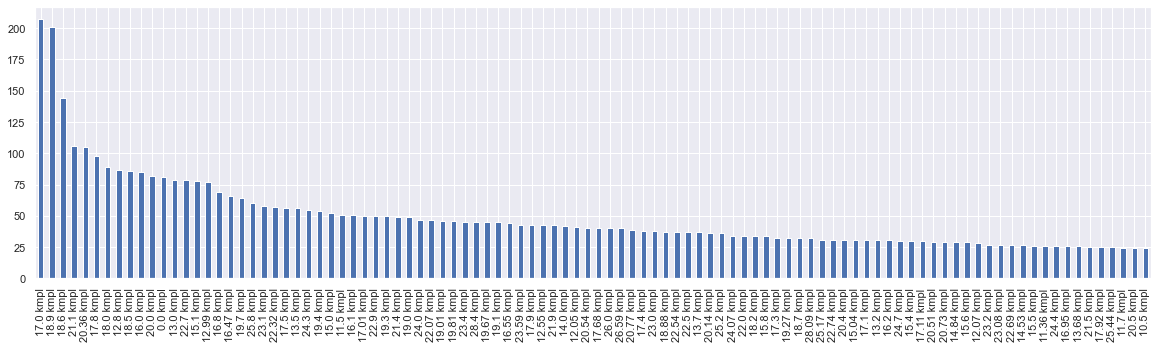

In [535]:
plt.figure(figsize=(20,5))
df['Mileage'].value_counts().head(100).plot.bar()
plt.show()

In [536]:
df['Mileage'] = df['Mileage'].fillna('17.0 kmpl')
#I also notice few rows having 0.0 kmpl. we need to replace that too.
df['Mileage'] = df['Mileage'].replace("0.0 kmpl", "17.0 kmpl")

I am imputing the missing values with the maximum occurence for the column, in this case it's "17.0 kmpl". Also there are few 0 values. I am replacing them also with maximum value

Now, let's try to split the `Mileage` column and try to understand why some of the records are in km/kg. I am storing the units and values in separate columns. In addition converted the mileage values to float

In [537]:
mileage = df["Mileage"].str.split(" ", n = 1, expand = True)
df.drop(['Mileage'], axis=1, inplace=True)
df["mileage_unit"]= mileage[1]   
df["mileage_value"]= mileage[0]
df.loc[:,'mileage_value'] = df["mileage_value"].apply(lambda x: float(x))

In [538]:
df[df['mileage_unit']=='km/kg']

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,New_Price,Price,Model,Brand,mileage_unit,mileage_value
0,Mumbai,2010,72000,CNG,Manual,First,998 CC,58.16 bhp,5.0,NaN,1.8,Wagon R LXI CNG,maruti,km/kg,26.6
5,Hyderabad,2012,75000,LPG,Manual,First,814 CC,55.2 bhp,5.0,NaN,2.4,EON LPG Era Plus Option,hyundai,km/kg,21.1
127,Pune,2013,89900,CNG,Manual,First,998 CC,58.16 bhp,5.0,NaN,3.2,Wagon R LXI CNG,maruti,km/kg,26.6
328,Pune,2008,42496,CNG,Manual,First,998 CC,67.1 bhp,5.0,NaN,1.4,Zen Estilo LXI Green (CNG),maruti,km/kg,26.3
440,Kochi,2017,31841,CNG,Manual,First,1196 CC,73 bhp,5.0,NaN,4.7,Eeco 5 STR With AC Plus HTR CNG,maruti,km/kg,15.1
839,Delhi,2012,65537,CNG,Manual,First,796 CC,38.4 bhp,5.0,NaN,2.1,Alto Green LXi (CNG),maruti,km/kg,26.8
893,Hyderabad,2010,95637,CNG,Manual,Second,1495 CC,93.7 bhp,5.0,NaN,1.9,Accent Executive CNG,hyundai,km/kg,13.2
936,Hyderabad,2012,72000,LPG,Manual,First,998 CC,58.2 bhp,5.0,NaN,2.9,Wagon R LXI LPG BSIV,maruti,km/kg,26.2
987,Mumbai,2008,64226,LPG,Manual,First,1061 CC,57.5 bhp,5.0,NaN,1.4,Wagon R LXI DUO BSIII,maruti,km/kg,17.3
1135,Ahmedabad,2011,76000,CNG,Manual,First,998 CC,67.1 bhp,5.0,NaN,2.0,Zen Estilo LXI Green (CNG),maruti,km/kg,26.3


I notice that the rows with 'km/kg' are CNG or LPG fuel type vehicles. Hence conversion from km/kg to km/l may not be appropriate.

### 4.3 Missing value treatment for `Engine`
There are 46 missing values for `Engine` column. Need to analyze more in detail

In [539]:
mdl = df[df['Engine'].isnull()]
mdl

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,New_Price,Price,Model,Brand,mileage_unit,mileage_value
194,Ahmedabad,2007,60006,Petrol,Manual,First,NaN,NaN,nan,NaN,3.0,City 1.5 GXI,honda,kmpl,17.0
208,Kolkata,2010,42001,Petrol,Manual,First,NaN,NaN,nan,NaN,2.1,Swift 1.3 VXi,maruti,kmpl,16.1
733,Chennai,2006,97800,Petrol,Manual,Third,NaN,NaN,nan,NaN,1.8,Swift 1.3 VXi,maruti,kmpl,16.1
749,Mumbai,2008,55001,Diesel,Automatic,Second,NaN,NaN,nan,NaN,26.5,Rover Range Rover 3.0 D,land rover,kmpl,17.0
1294,Delhi,2009,55005,Petrol,Manual,First,NaN,NaN,nan,NaN,3.2,City 1.3 DX,honda,kmpl,12.8
1327,Hyderabad,2015,50295,Petrol,Manual,First,NaN,NaN,nan,NaN,5.8,Swift 1.3 ZXI,maruti,kmpl,16.1
1385,Pune,2004,115000,Petrol,Manual,Second,NaN,NaN,nan,NaN,1.5,City 1.5 GXI,honda,kmpl,17.0
1460,Coimbatore,2008,69078,Petrol,Manual,First,NaN,NaN,nan,NaN,40.9,Rover Range Rover Sport 2005 2012 Sport,land rover,kmpl,17.0
2074,Pune,2011,24255,Petrol,Manual,First,NaN,NaN,nan,NaN,3.1,Swift 1.3 LXI,maruti,kmpl,16.1
2096,Coimbatore,2004,52146,Petrol,Manual,First,NaN,NaN,nan,NaN,1.9,Santro LP zipPlus,hyundai,kmpl,17.0


The above table confirms that certain columns tend to be missing together - like `Engine`, `power` and `seats`. I am trying to replace the missing values of engine, power and seats with the values of the same car models from other rows

In [540]:
car_lst = mdl['Model'].unique()
car_lst

array(['City 1.5 GXI', 'Swift 1.3 VXi', 'Rover Range Rover 3.0 D',
       'City 1.3 DX', 'Swift 1.3 ZXI',
       'Rover Range Rover Sport 2005 2012 Sport', 'Swift 1.3 LXI',
       'Santro LP zipPlus', 'Etios Liva V', 'Swift 1.3 VXI ABS',
       '5 Series 520d Sedan', 'Santro GLS II - Euro II', 'Wagon R Vx',
       'CR-V AT With Sun Roof', 'Punto 1.3 Emotion', 'Santro Xing XG',
       'Jazz Select Edition', 'Punto 1.2 Dynamic', 'Punto 1.4 Emotion',
       'Laura 1.8 TSI Ambition', 'Etios Liva Diesel TRD Sportivo',
       'i20 new Sportz AT 1.4', 'TUV 300 P4'], dtype=object)

These are the unique car models with missing values

In [541]:
df1 = df.loc[df['Model'].isin(car_lst)][['Engine', 'Power', 'Seats', 'Model']].dropna()
df1

,Engine,Power,Seats,Model
3145,1198 CC,88.8 bhp,5.0,Jazz Select Edition
3305,1493 CC,100 bhp,5.0,City 1.5 GXI
4138,1197 CC,78.9 bhp,5.0,Etios Liva V
4767,1493 CC,100 bhp,5.0,City 1.5 GXI


The above output shows that there are few models with values that I can use to impute the missing values. However, it appears that I can fill the missing values for only few car models with the above approach. For the remaining missing values, I am going to impute with the values that occur the most for those columns.

Below, I am filling the missing values from values of the same model car

In [542]:
# filling the missing values for Engine
df.loc[df['Model']=="Jazz Select Edition", 'Engine'] = df.loc[df['Model']=="Jazz Select Edition", 'Engine'].fillna(1198, inplace = True)
df.loc[df['Model']=="City 1.5 GXI", 'Engine'] = df.loc[df['Model']=="City 1.5 GXI", 'Engine'].fillna(1493, inplace = True)
df.loc[df['Model']=="Etios Liva V", 'Engine'] = df.loc[df['Model']=="Etios Liva V", 'Engine'].fillna(1197, inplace = True)

I am going to plot the Mileage values and see the occurence of the values

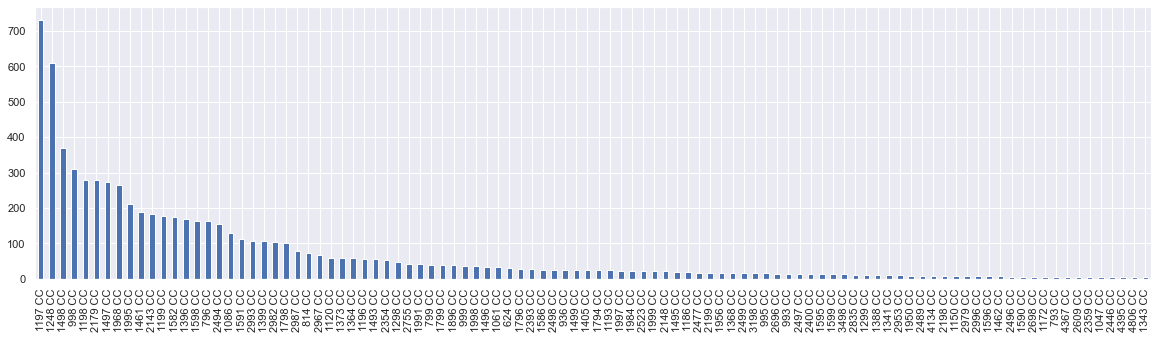

In [543]:
plt.figure(figsize=(20,5))
df['Engine'].value_counts().head(100).plot.bar()
plt.show()

In [544]:
df['Engine'] = df['Engine'].fillna('1197 CC')

Replaced with the maximum occurence of the `Engine` value. I am now splitting the values to remove the 'CC' text. In addition, converting it to int

In [545]:
engine = df["Engine"].str.split(" ", n = 1, expand = True)
df["Engine"] = engine[0]
df.loc[:,'Engine'] = df["Engine"].apply(lambda x: int(x))

Now, that the missing values are treated, I am coverting the column to int

### 4.4. Missing value treatment for `Power`
There are 46 missing values for `Power` column. I am going to impute the missing values and convert it to float. First, I am replacing the missing values from the values of the same car model. However, it can only impute for few of the models. For the remainder, I am using the maximum occurence to impute

In [546]:
# filling the missing values for Power
df.loc[df['Model']=="Jazz Select Edition", 'Power'] = df.loc[df['Model']=="Jazz Select Edition", 'Power'].fillna(88.8, inplace = True)
df.loc[df['Model']=="City 1.5 GXI", 'Power'] = df.loc[df['Model']=="City 1.5 GXI", 'Power'].fillna(100, inplace = True)
df.loc[df['Model']=="Etios Liva V", 'Power'] = df.loc[df['Model']=="Etios Liva V", 'Power'].fillna(78.9, inplace = True)

I am going to plot the Power values and see the occurence of the values

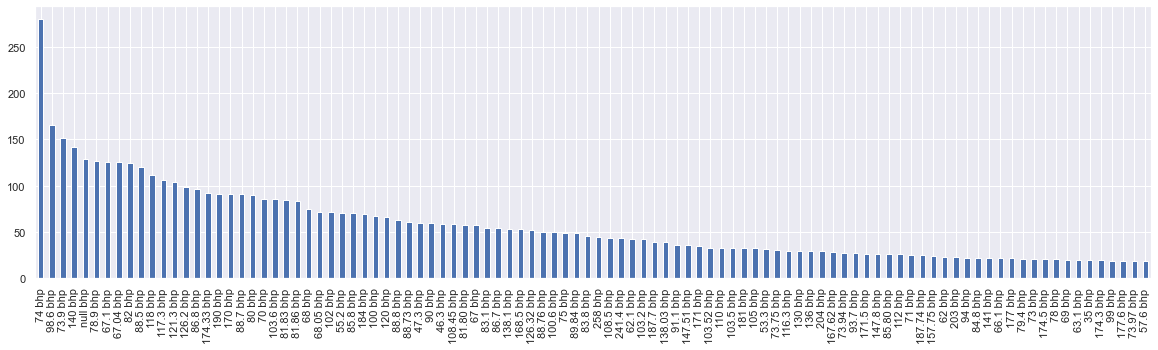

In [547]:
plt.figure(figsize=(20,5))
df['Power'].value_counts().head(100).plot.bar()
plt.show()

Replacing the missing values with the maximum occurence of the `Power` value

In [548]:
df['Power'] = df['Power'].fillna('74 bhp')
#I noticed there are few null bhp. I replaced that too. 
df['Power'] = df['Power'].replace("null bhp", "74 bhp")

Now, splitting the `Power` column to remove 'bhp' text

In [549]:
power = df["Power"].str.split(" ", n = 1, expand = True)
df["Power"] = power[0]
df=df[df["Power"]!='null']
df.loc[:,'Power'] = df["Power"].apply(lambda x: float(x))

Now the missing values are treated. I am converting it to float

### 4.5 Missing value treatment for `Seats`
There are 53 missing values for `Seats` column. I am going to impute the missing values and convert it to Int. First, I am replacing the missing values from the values of the same car model. However, it can only impute for few of the models. For the remainder, I will use the maximum occurences to impute

In [550]:
# filling the missing values for Seats
df.loc[df['Model']=="Jazz Select Edition", 'Seats'] = df.loc[df['Model']=="Jazz Select Edition", 'Seats'].fillna(5.0, inplace = True)
df.loc[df['Model']=="City 1.5 GXI", 'Seats'] = df.loc[df['Model']=="City 1.5 GXI", 'Seats'].fillna(5.0, inplace = True)
df.loc[df['Model']=="Etios Liva V", 'Seats'] = df.loc[df['Model']=="Etios Liva V", 'Seats'].fillna(5.0, inplace = True)

I am going to plot the Seats values and see the occurence of the values

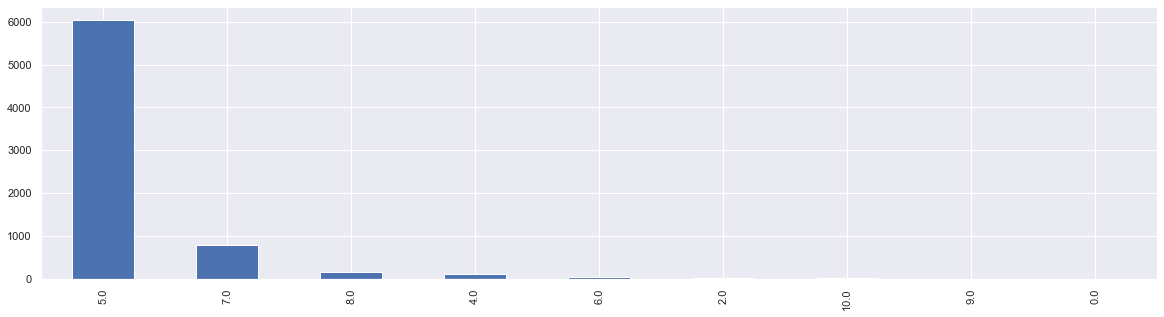

In [551]:
plt.figure(figsize=(20,5))
df['Seats'].value_counts().head(100).plot.bar()
plt.show()

Replacing with the maximum occurence of the `Seats` value

In [552]:
df['Seats'] = df['Seats'].fillna(5.0)
#There are few 0. seats as well. I replaced that too. 
df['Seats'] = df['Seats'].replace(0., 5.0)

Now the missing values are treated. I will convert it to Int

In [553]:
df['Seats'] = df['Seats'].astype(int)

I will now converting all the category fields to lower case to avoid any duplicate values as a result of data stored in different letter cases

In [554]:
df.Brand = df.Brand.str.lower()
df.Model = df.Model.str.lower()
df.Location = df.Location.str.lower()
df.Fuel_Type = df.Fuel_Type.str.lower()
df.Transmission = df.Transmission.str.lower()
df.Owner_Type = df.Owner_Type.str.lower()

Converting few of the category columns to numeric. Since there are too many distinct values to convert to dummy variables, I am trying to convert `Location`, `model`, `brand` and `mileage unit` to numeric and keeping other category colums as is

In [555]:
df['Location'] = df['Location'].astype('category').cat.codes
df['Model'] = df['Model'].astype('category').cat.codes
df['Brand'] = df['Brand'].astype('category').cat.codes
df['mileage_unit'] = df['mileage_unit'].astype('category').cat.codes

### 4.7 Missing value treatment for `Price`
There are 1234 missing values for `Price`. First I need to impute the missing values and then convert `Price` to the full currency value in Lakhs. For price imputation, I am thinking to use mean or median. Let's analyze to see which one may be the right option. I want to plot the price to see the distribution

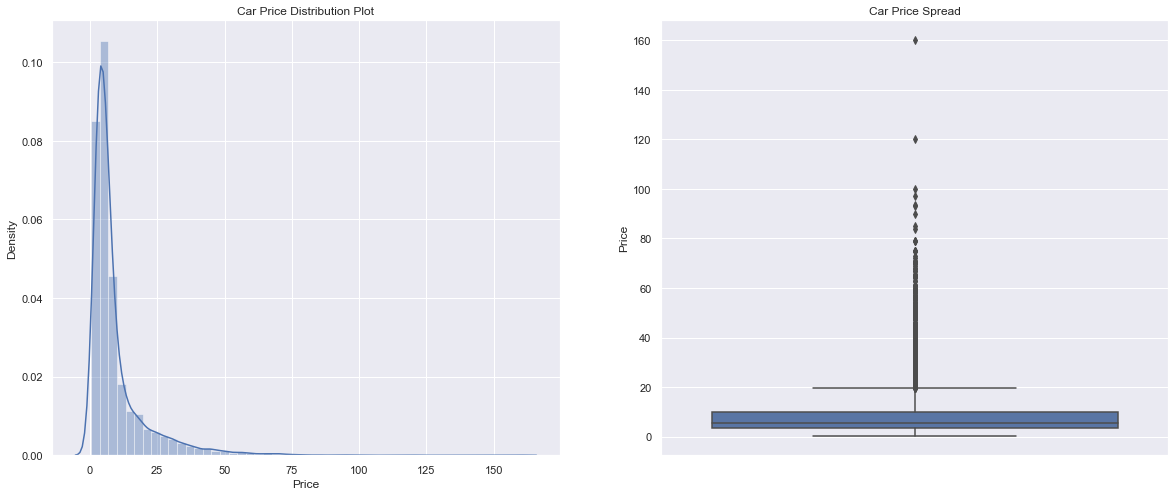

In [556]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(df.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=df.Price)

plt.show()

From the above chart, it's clear that the price is right skewed

In [557]:
print(df.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count   6019.0
mean       9.5
std       11.2
min        0.4
25%        3.5
50%        5.6
75%        9.9
85%       16.5
90%       22.5
100%     160.0
max      160.0
Name: Price, dtype: float64


As you can see from the above output. There is a huge variation from the 90% to 100%. Hence mean would not be the right approach for impution, I am planning to use median instead

In [558]:
df['Price'].fillna(df['Price'].median(), inplace = True)

Converting to the full currency value in Lakhs

In [559]:
df['Price'] = df['Price']*100000

# 5. Data Exploratory Analysis

In [560]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,7253.0,5.6,3.0,0.0,3.0,6.0,8.0,10.0
Year,7253.0,2013.4,3.3,1996.0,2011.0,2014.0,2016.0,2019.0
Kilometers_Driven,7253.0,58699.1,84427.7,171.0,34000.0,53416.0,73000.0,6500000.0
Engine,7253.0,1613.8,594.4,72.0,1197.0,1462.0,1968.0,5998.0
Power,7253.0,111.8,53.2,34.2,74.0,91.1,138.0,616.0
Seats,7253.0,5.3,0.8,2.0,5.0,5.0,5.0,10.0
Price,7253.0,882623.5,1029331.3,44000.0,385000.0,564000.0,840000.0,16000000.0
Model,7253.0,984.5,594.4,0.0,470.0,923.0,1538.0,2016.0
Brand,7253.0,15.9,8.1,0.0,10.0,17.0,19.0,31.0
mileage_unit,7253.0,1.0,0.1,0.0,1.0,1.0,1.0,1.0


* Year varies from 1996 to 2019
* Avg price is 882623.5
* no. of seats in the car varies from 2 to 10

### 5.1 Univariate Analysis

In [561]:
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    sns.set(font_scale=2) # setting the font scale  of the seaborn
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='red') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(feature.mean(), color='g', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(feature.median(), color='black', linestyle='-') # Add median to the histogram

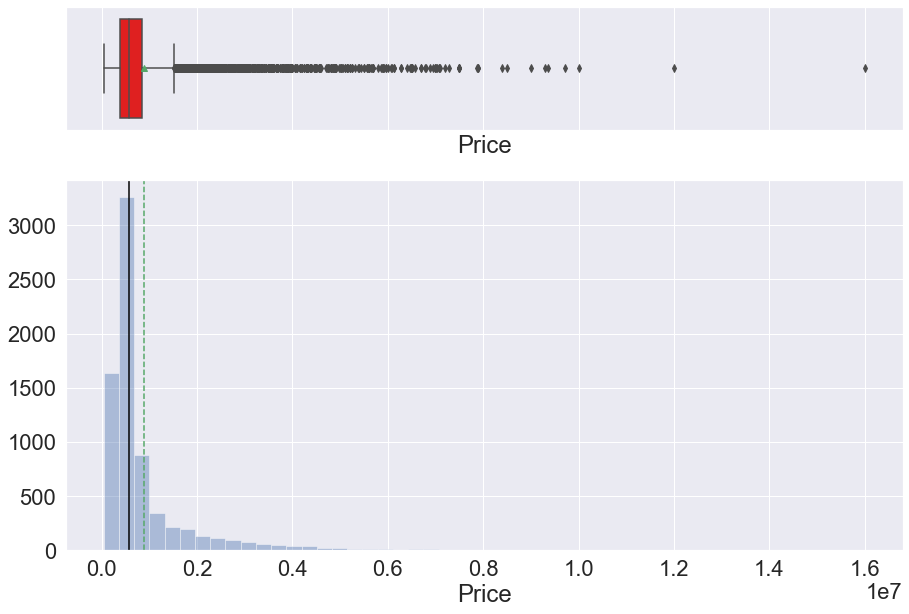

In [562]:
histogram_boxplot(df.Price)

In [563]:
print(df.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count       7253.0
mean      882623.5
std      1029331.3
min        44000.0
25%       385000.0
50%       564000.0
75%       840000.0
85%      1355200.0
90%      1950000.0
100%    16000000.0
max     16000000.0
Name: Price, dtype: float64


`Price` looks to be right-skewed, meaning that the most prices in the dataset are low(Below 564000). There is a significant difference between the mean and the median of the price distribution. The data points are far spread out from the mean, which indicates a high variance in the car prices.(90% of the prices are below 1950000, whereas the remaining 10% are between 1950000 and 16000000

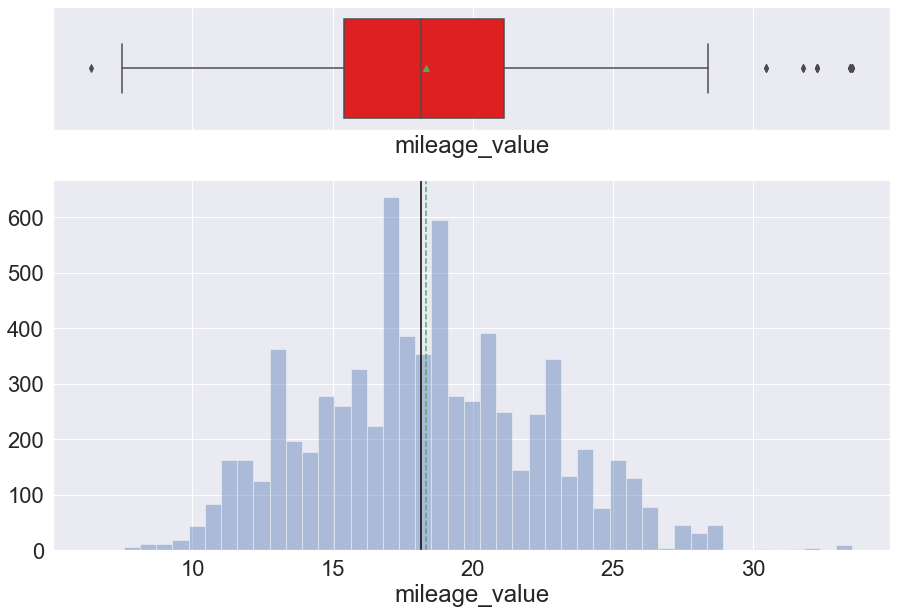

In [564]:
histogram_boxplot(df.mileage_value)

In [565]:
print(df.mileage_value.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count   7253.0
mean      18.3
std        4.1
min        6.4
25%       15.4
50%       18.2
75%       21.1
85%       22.9
90%       24.0
100%      33.5
max       33.5
Name: mileage_value, dtype: float64


`Mileage` seem to have the normal distribution-  the mean and median values are almost same. Although, there are few outliers. The data points are evenly spread out from the mean, which indicates a less variance in the Mileage

### 5.2 Distribution of each numerical variable.

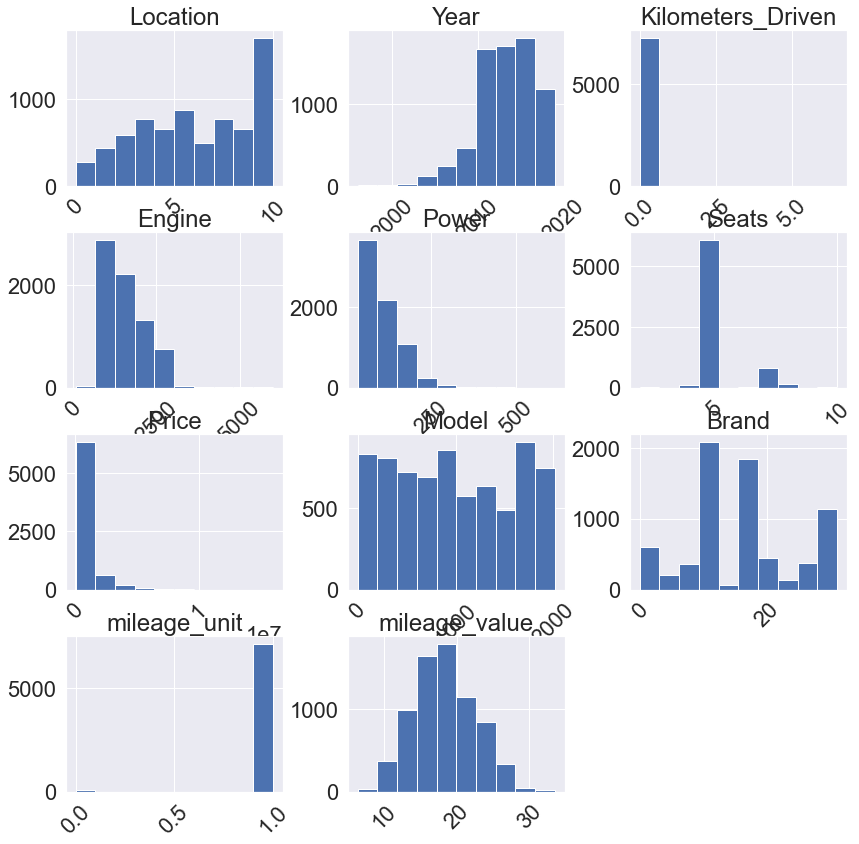

In [566]:
df.hist(figsize=(14,14), xrot=45)
plt.show()

### 5.3 Outliers in numerical columns

In [567]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

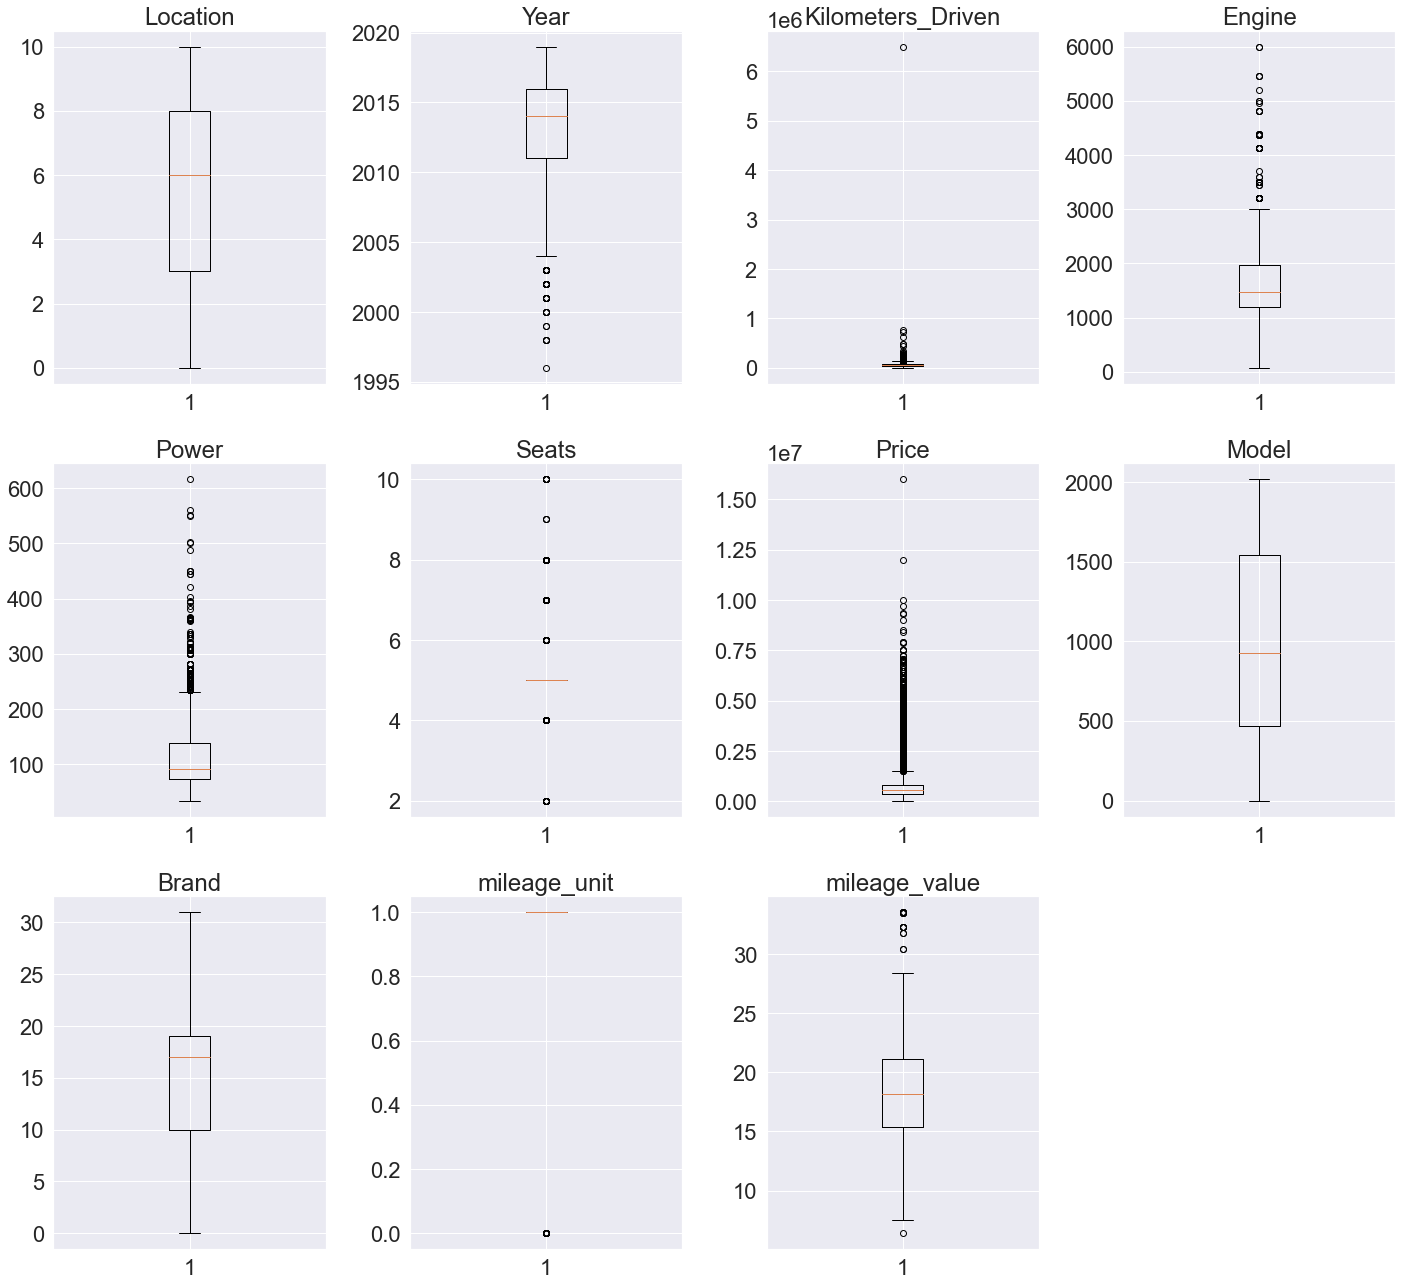

In [568]:
# outlier detection using boxplot
plt.figure(figsize=(20,30))

for i, variable in enumerate(numeric_columns):
                     plt.subplot(5,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

* There are no outliers for `Brand`, `Model`, `Transmission`, `Fuel Type` and `Location`
* There are lower outliers in `Year` and `mileage unit` 
* All other numerical columns have upper outliers
We will treat these outliers as these might adversely affect the predictive power of linear model.However this may be important information which we will understand by building model with outliers and comparing the model performances.

### 5.4 Bivariate Analysis

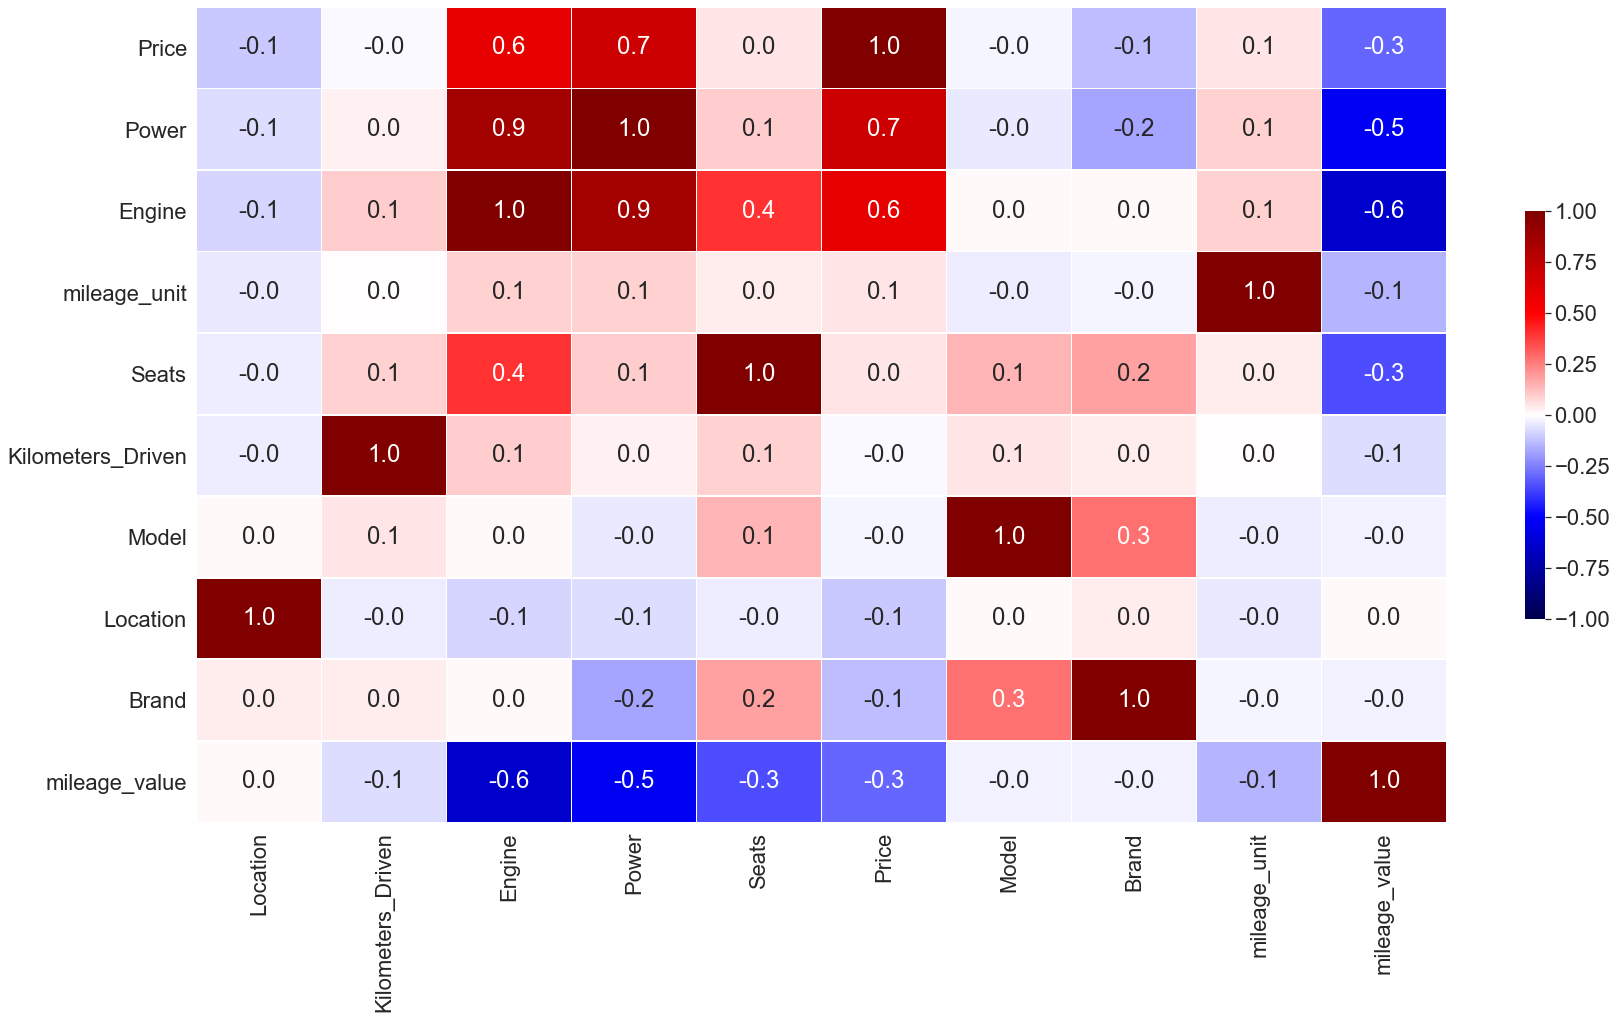

In [569]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
numeric_columns.remove('Year') # dropping year column as it is temporal variable
corr = df[numeric_columns].corr().sort_values(by=['Price'],ascending=False) # sorting correlations w.r.t Price  


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(28, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            cmap='seismic', annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0,
            square=False, linewidths=.7, cbar_kws={"shrink": .5});

The heatmap shows some useful insights:
Correlation of target variable `Price` with independent variables. Price is highly (positively) correlated with `Engine` and `Power`. Price is negatively correlated to `Mileage Value` and `Fuel Type` (-0.5, -0.30 approximately). This suggest that cars having high mileage may fall in the ‘economy’ cars category, and are priced lower.

Correlation among independent variables:
Few independent variables are highly correlated `Power` and `Engine` and are positively correlated. While building the model, we’ll have to pay attention to this multicollinearity

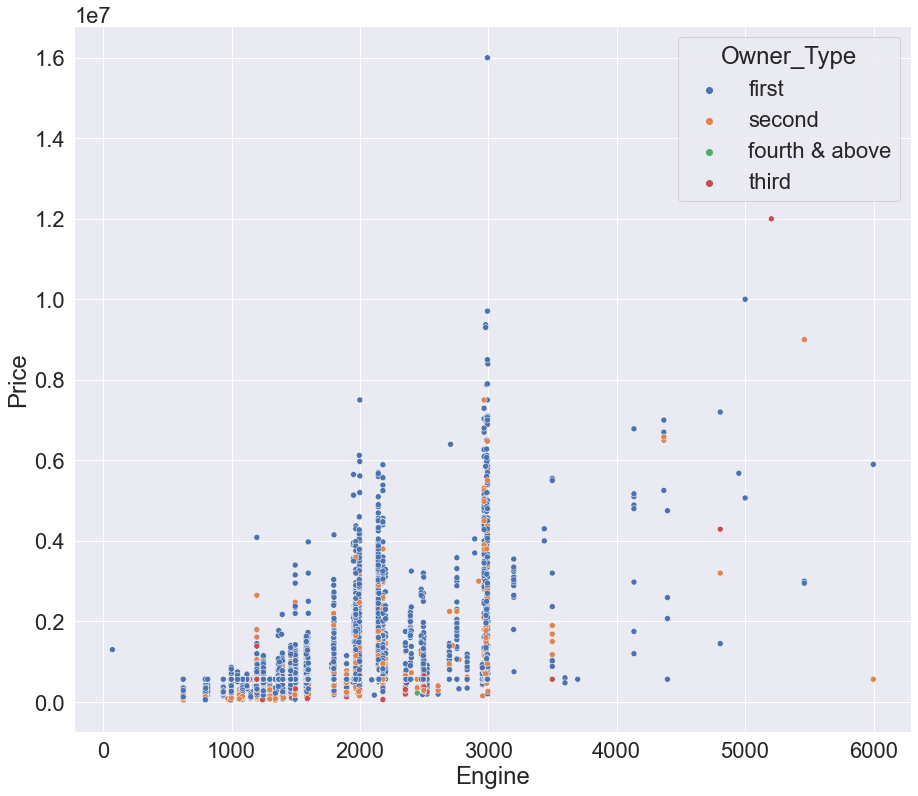

In [570]:
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='Engine', hue = 'Owner_Type', data=df);

Most of the car ownership are first-hand. There are few second and third hand ownership with high car prices.
There is a car which is third hand ownership with high price having powerful engine. Let's look at the data deeper

In [571]:
df[(df.Price > .4)& (df.Engine > 5000 ) & (df.Owner_Type =='third')]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,New_Price,Price,Model,Brand,mileage_unit,mileage_value
5781,4,2011,6500,petrol,automatic,third,5204,560.0,2,NaN,12000000.0,801,15,1,6.4


The data seem to suggest that there are few third hand cars that may be high valued luxury brands

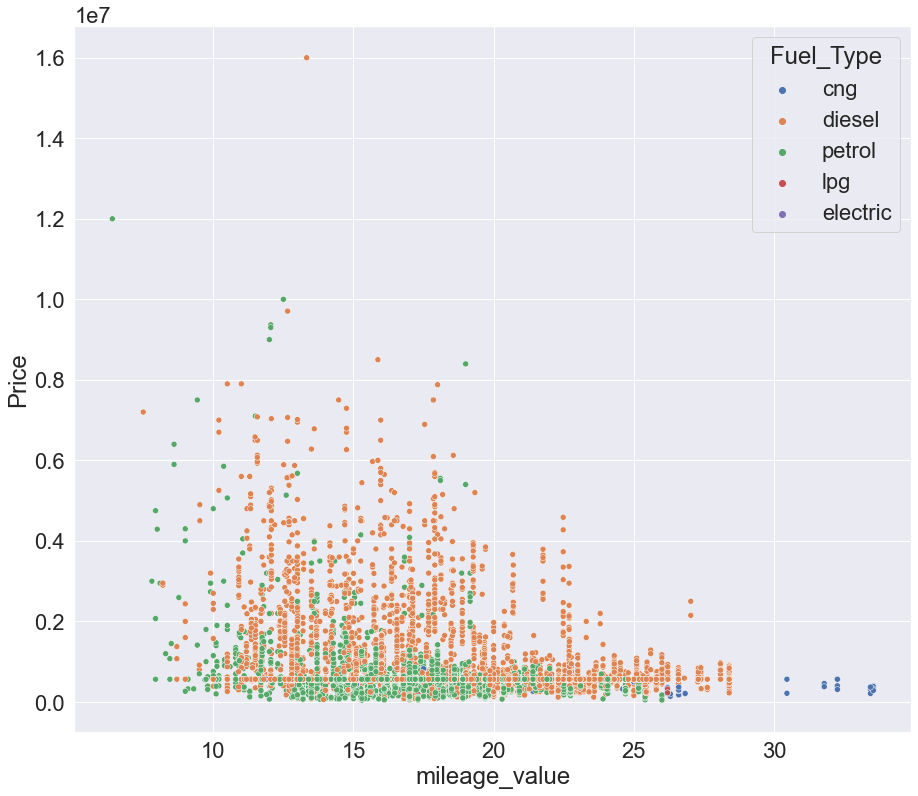

In [572]:
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='mileage_value', hue = 'Fuel_Type', data=df);

There are high number of diesel vehicles available for sale. The data does not show strong correlation between mileage and price. There are few CNG vehicles with high mileage value with lower prices. Overall diesel vehicle are more expensive than petrol vehicle, it seem to suggest that the diesiel vehicles have high resale value than other fuel type vehicles

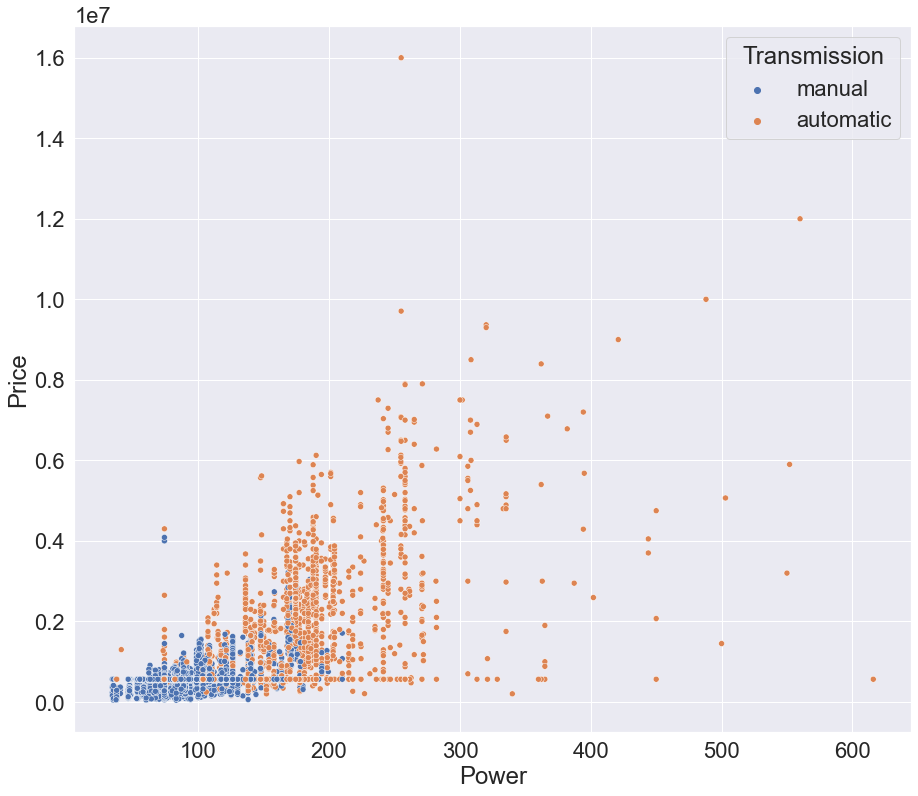

In [573]:
# Let's visualize the relationship 
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='Power', hue = 'Transmission', data=df);

There is a strong corelation between power and price. Data seem to suggest that powerful cars are expensive. Also, Automatic cars are more expensive than manual.

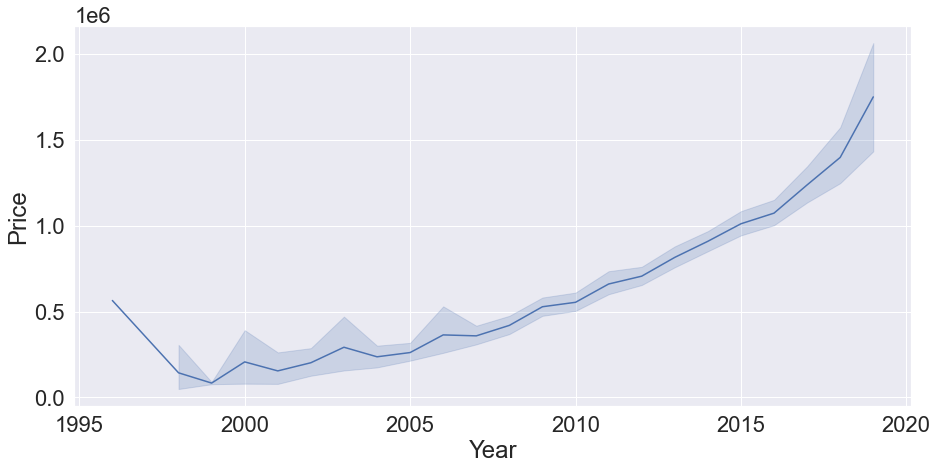

In [574]:
# How does life expectancy vary year by year?
plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='Price',
             data=df);

Newer cars are more expensive. Car model years between 2000 and 2005 have seen some price fluctuations

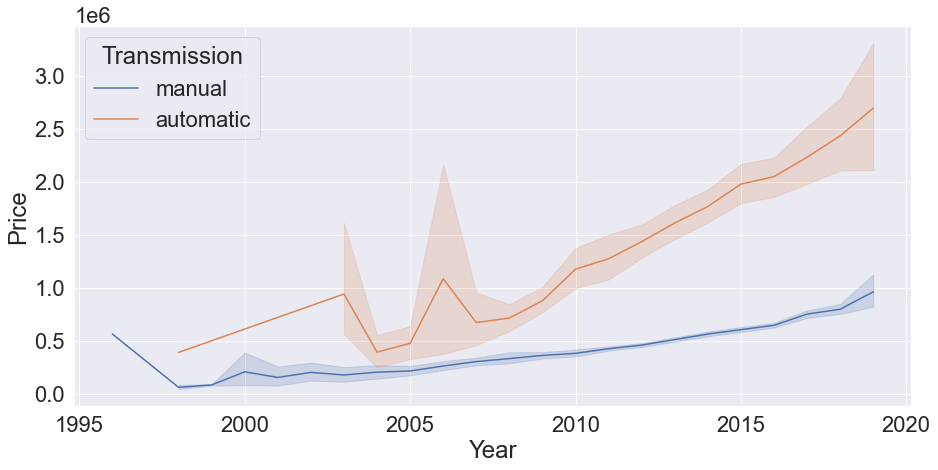

In [575]:
# How does life expectancy vary year by year?
plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='Price',hue='Transmission',
             data=df);

New car prices are more expensive in general. In addition automatic cars with newer models are even more expensive than the manual transmission cars. The gap is huge

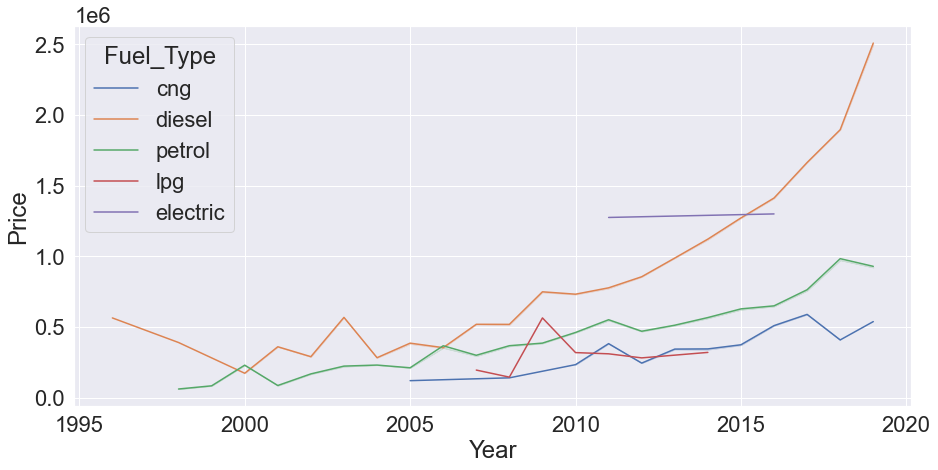

In [576]:
# How does life expectancy vary year by year?
plt.figure(figsize=(15,7))
sns.lineplot(x='Year', y='Price',hue='Fuel_Type',ci=0,
             data=df);

There are more newer model diesel vehicles that are high priced. Price for electric models seems flat betwen 2010 and 2015 and don't have data after 2015. Petrol and CNG cars have seen similar price trends from 2005 and 2017 models except the recent year models pertrol vehicle have higher prices than CNG

There are more diesel cars with newer models that are high priced than other fuel type cars. It suggests that New car models with deisel type have high resale value

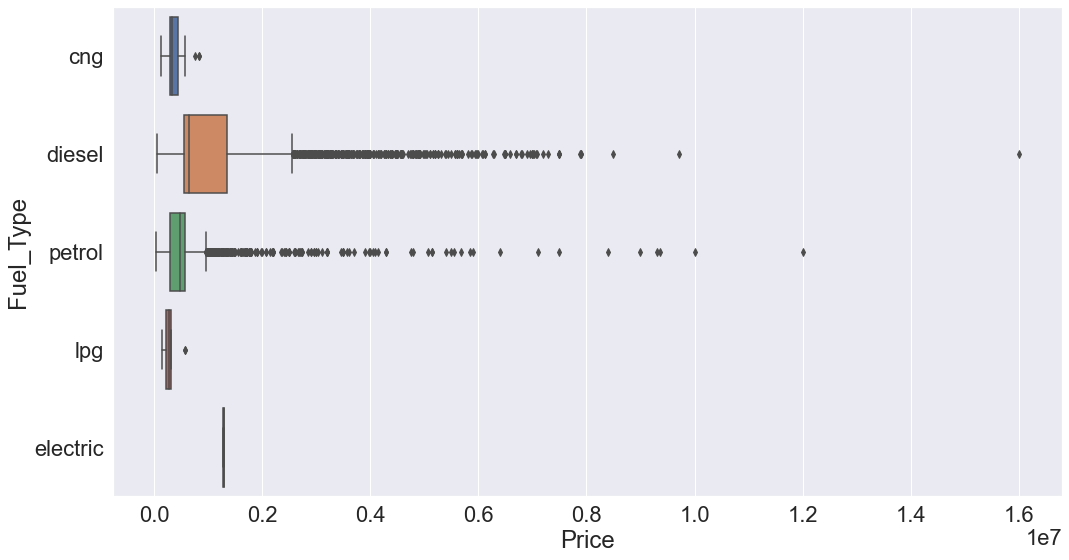

In [577]:
plt.figure(figsize=(17,9))
sns.boxplot(y='Fuel_Type',x="Price",data=df)
plt.show()

Diesel cars more expensive than other fuel type cars. CNG and petrol have similar price trends

# 6. Data Preparation

### 6.1 Outliers Treatment
We observered outliers with several numeric varibles. Outliers affect the model score hence it needs to be treated

In [578]:
def treat_outliers(df,col):
    '''
    treats outliers in a variable
    col: str, name of the numerical variable
    df: data frame
    col: name of the column
    '''
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df

Treating the outliers

In [579]:
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
df = treat_outliers_all(df,numerical_col)

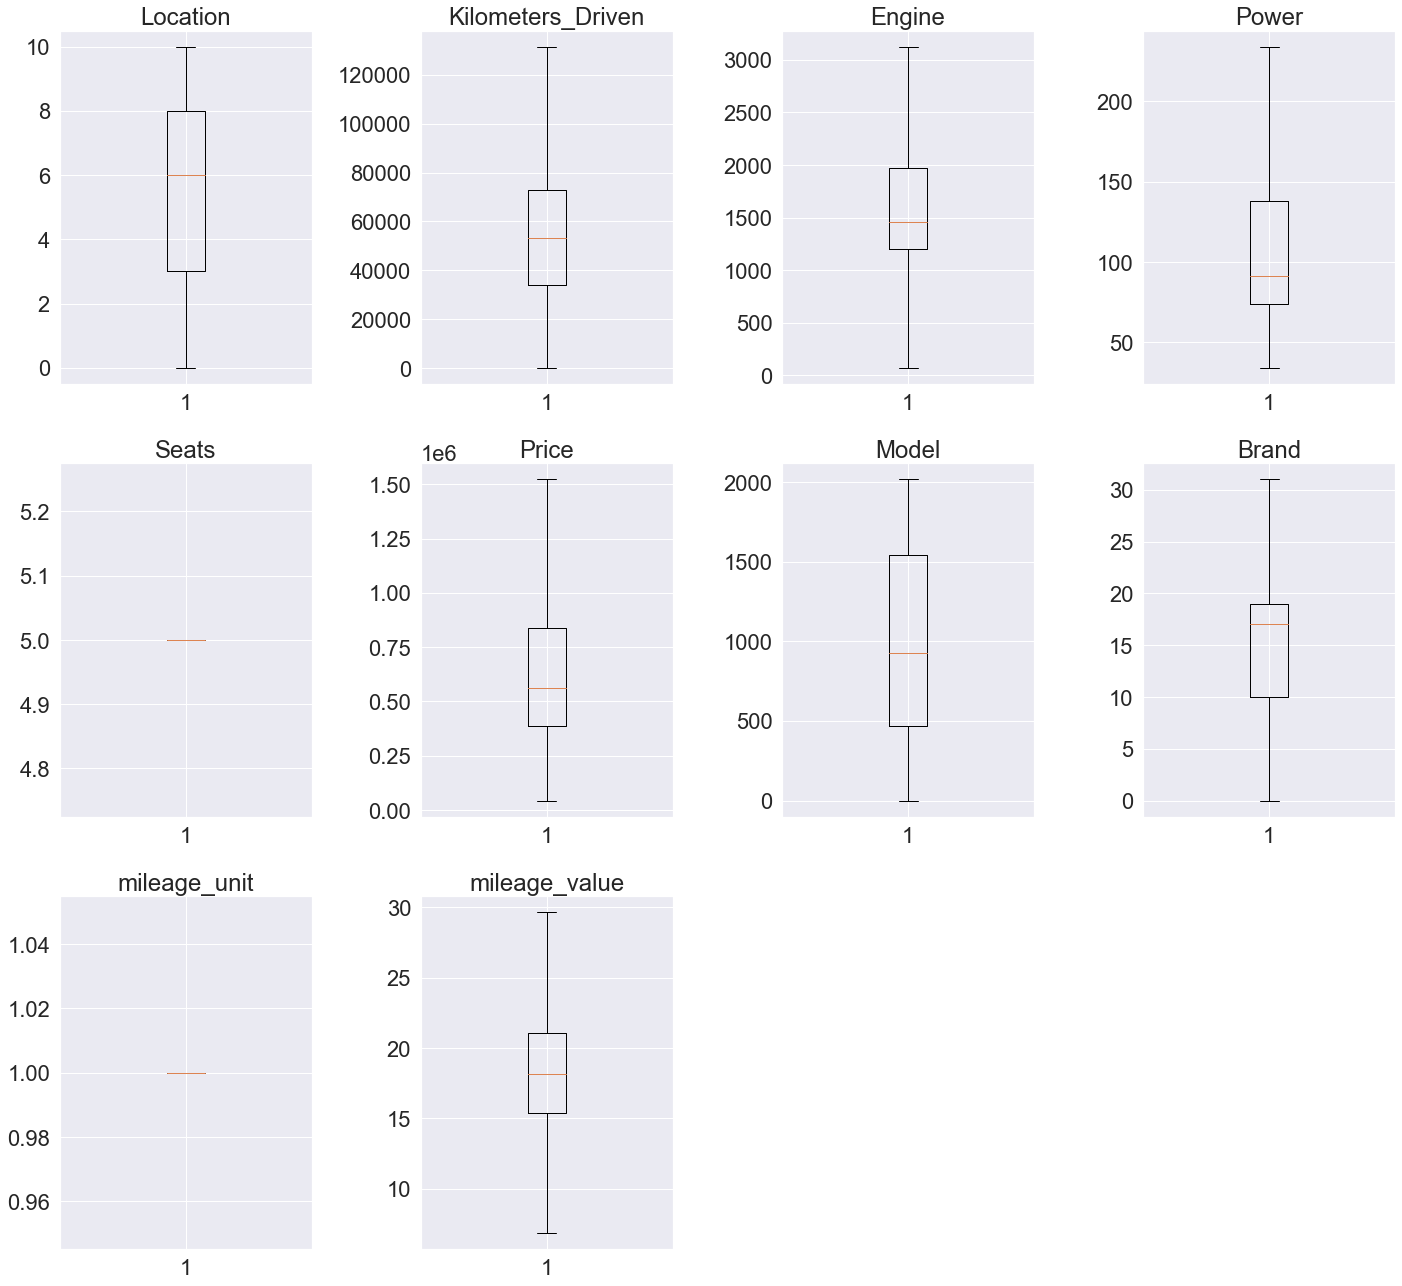

In [580]:
# let's look at box plot to see if outliers has been treated or not
plt.figure(figsize=(20,30))

for i, variable in enumerate(numeric_columns):
                     plt.subplot(5,4,i+1)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

Outliers are treated

# 6. Model Building - Linear Regression

### 6.1 Model 1: without feature exclusion - except new price

In [581]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,New_Price,Price,Model,Brand,mileage_unit,mileage_value
0,9,2010.0,72000,cng,manual,first,998.0,58.2,5,NaN,175000.0,1864,18,1,26.6
1,10,2015.0,41000,diesel,manual,first,1582.0,126.2,5,NaN,1250000.0,493,11,1,19.7
2,2,2011.0,46000,petrol,manual,first,1199.0,88.7,5,8.61 Lakh,450000.0,1075,10,1,18.2
3,2,2012.0,87000,diesel,manual,first,1248.0,88.8,5,NaN,600000.0,669,18,1,20.8
4,3,2013.0,40670,diesel,automatic,second,1968.0,140.8,5,NaN,1522500.0,105,1,1,15.2


In [582]:
#Defining X and y variables. Excluding new price since it's the for the price of new car and this analysis is around used cars
X = df.drop(['Price','New_Price'], axis=1)
y = df[['Price']]

print(X.head())
print(y.head())

   Location   Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
0         9 2010.0              72000       cng       manual      first   
1        10 2015.0              41000    diesel       manual      first   
2         2 2011.0              46000    petrol       manual      first   
3         2 2012.0              87000    diesel       manual      first   
4         3 2013.0              40670    diesel    automatic     second   

   Engine  Power  Seats  Model  Brand  mileage_unit  mileage_value  
0   998.0   58.2      5   1864     18             1           26.6  
1  1582.0  126.2      5    493     11             1           19.7  
2  1199.0   88.7      5   1075     10             1           18.2  
3  1248.0   88.8      5    669     18             1           20.8  
4  1968.0  140.8      5    105      1             1           15.2  
      Price
0  175000.0
1 1250000.0
2  450000.0
3  600000.0
4 1522500.0


In [583]:
print(X.shape)
print(y.shape)

(7253, 13)
(7253, 1)


### 6.2 Create Dummy Variables
The dataset contains few categorical values. So, in-order to use those categorical value for programming efficiently we create dummy variables. A dummy variable is a binary variable that indicates whether a separate categorical variable takes on a specific value.

In [584]:
X = pd.get_dummies(X, columns=['Fuel_Type', 'Owner_Type', 'Transmission'], drop_first=True)
X.head()

,Location,Year,Kilometers_Driven,Engine,Power,Seats,Model,Brand,mileage_unit,mileage_value,Fuel_Type_diesel,Fuel_Type_electric,Fuel_Type_lpg,Fuel_Type_petrol,Owner_Type_fourth & above,Owner_Type_second,Owner_Type_third,Transmission_manual
0,9,2010.0,72000,998.0,58.2,5,1864,18,1,26.6,0,0,0,0,0,0,0,1
1,10,2015.0,41000,1582.0,126.2,5,493,11,1,19.7,1,0,0,0,0,0,0,1
2,2,2011.0,46000,1199.0,88.7,5,1075,10,1,18.2,0,0,0,1,0,0,0,1
3,2,2012.0,87000,1248.0,88.8,5,669,18,1,20.8,1,0,0,0,0,0,0,1
4,3,2013.0,40670,1968.0,140.8,5,105,1,1,15.2,1,0,0,0,0,1,0,0


Splitting data into train and test

In [585]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [586]:
X_train.head()

,Location,Year,Kilometers_Driven,Engine,Power,Seats,Model,Brand,mileage_unit,mileage_value,Fuel_Type_diesel,Fuel_Type_electric,Fuel_Type_lpg,Fuel_Type_petrol,Owner_Type_fourth & above,Owner_Type_second,Owner_Type_third,Transmission_manual
3181,2,2014.0,52000,998.0,67.0,5,1872,18,1,22.5,0,0,0,1,0,0,0,1
952,3,2018.0,92056,2393.0,147.8,5,1052,29,1,13.7,1,0,0,0,0,0,0,1
2266,6,2009.0,131500,2982.0,171.0,5,786,29,1,11.5,1,0,0,0,0,0,0,1
1504,7,2017.0,43775,1248.0,88.8,5,669,18,1,20.8,1,0,0,0,0,0,0,1
7213,5,2013.0,131500,1248.0,74.0,5,990,28,1,22.3,1,0,0,0,0,0,0,1


### 6.2 Choose Model, Train and Evaluate

In [587]:
#Fitting linear model
lin_reg_model = LinearRegression()                                    
lin_reg_model.fit(X_train, y_train)   

LinearRegression()

In [588]:
# let us check the coefficients and intercept of the model

coef_df = pd.DataFrame(np.append(lin_reg_model.coef_.flatten(), lin_reg_model.intercept_), \
                       index=X_train.columns.tolist()+['Intercept'], columns=['Coefficients'])
print(coef_df)

                           Coefficients
Location                        -4739.1
Year                            40482.1
Kilometers_Driven                  -0.7
Engine                             68.2
Power                            3641.5
Seats                               0.0
Model                             -34.8
Brand                             452.0
mileage_unit                       -0.0
mileage_value                  -11695.3
Fuel_Type_diesel                60808.1
Fuel_Type_electric             699806.7
Fuel_Type_lpg                   10371.9
Fuel_Type_petrol               -87432.8
Owner_Type_fourth & above      132886.2
Owner_Type_second               -6779.1
Owner_Type_third               -56576.5
Transmission_manual           -142528.0
Intercept                   -80913396.1


In [589]:

# MAPE
def mape(targets, predictions):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

# Adjusted R^2
def adj_r2(ind_vars, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = ind_vars.shape[0]
    k = ind_vars.shape[1]
    return 1-((1-r2)*(n-1)/(n-k-1))

# Model performance check
def model_perf(model, inp, out):

    y_pred = model.predict(inp)
    y_act = out.values

    return pd.DataFrame({
                "MAE": mean_absolute_error(y_act, y_pred),
                "MAPE": mape(y_act, y_pred),
                "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
                "R^2": r2_score(y_act, y_pred),
                "Adjusted R^2": adj_r2(inp, y_act, y_pred)
           }, index=[0]), y_pred


In [590]:
model_score_train, y_pred = model_perf(model=lin_reg_model,
                                 inp=X_train,
                                 out=y_train)

In [591]:
# Checking model performance on train set
print('Training Performance\n')
print(model_score_train)

Training Performance

       MAE  MAPE     RMSE  R^2  Adjusted R^2
0 172469.7  32.4 237478.7  0.7           0.7


In [592]:
model_score_test, y_pred = model_perf(model=lin_reg_model,
                                 inp=X_test,
                                 out=y_test)

In [593]:
# Checking model performance on test set
print('Test Performance\n')
print(model_score_test)

Test Performance

       MAE  MAPE     RMSE  R^2  Adjusted R^2
0 167213.5  31.4 229384.2  0.7           0.7


In [594]:
results_comparison = pd.concat([pd.DataFrame(y_pred),pd.DataFrame(y_train.values)],axis=1)
results_comparison.columns = ['pred', 'actual']

<Figure size 2000x600 with 0 Axes>

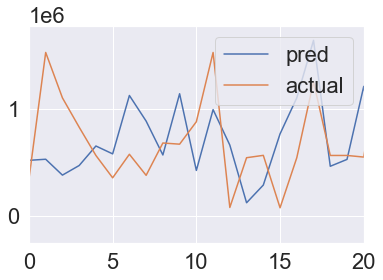

<Figure size 2000x600 with 0 Axes>

In [595]:
import matplotlib.pyplot as plt
plt.plot(results_comparison.index, results_comparison['pred'], label='pred')
plt.plot(results_comparison.index, results_comparison['actual'], label='actual')
plt.legend()
plt.xlim(0,20)
figure(figsize=(20, 6), dpi=100)

* The training and testing RMSE are comparable. Hence, the model is a reasonably good fit.
* $R^2$ is 0.7, that explains ~70% of total variation in the dataset. So, overall the model is satisfactory.

## 7. Model Performance Evaluation

### 7.1 Feature Selection with filter method using pearson correlation

In [596]:
df.corr()

,Location,Year,Kilometers_Driven,Engine,Power,Seats,Price,Model,Brand,mileage_unit,mileage_value
Location,1.0,-0.0,-0.1,-0.1,-0.1,nan,-0.1,0.0,0.0,nan,0.0
Year,-0.0,1.0,-0.5,-0.0,0.0,nan,0.4,-0.0,0.0,nan,0.3
Kilometers_Driven,-0.1,-0.5,1.0,0.2,0.0,nan,-0.2,0.1,0.1,nan,-0.2
Engine,-0.1,-0.0,0.2,1.0,0.8,nan,0.6,0.0,0.0,nan,-0.6
Power,-0.1,0.0,0.0,0.8,1.0,nan,0.7,-0.0,-0.2,nan,-0.6
Seats,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Price,-0.1,0.4,-0.2,0.6,0.7,nan,1.0,-0.1,-0.1,nan,-0.3
Model,0.0,-0.0,0.1,0.0,-0.0,nan,-0.1,1.0,0.3,nan,-0.0
Brand,0.0,0.0,0.1,0.0,-0.2,nan,-0.1,0.3,1.0,nan,-0.0
mileage_unit,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [597]:
df[['Engine', 'Power']].corr()

,Engine,Power
Engine,1.0,0.8
Power,0.8,1.0


`Engine` and `Power` have strong correlation with `Price` and `Brand`, `mileage value` and `Location` have weak correlation with `Price`. Also there is high multicolinealiry between `Engine` and `Power`. As `Power` have high correlation with `Price` as `oppose` to `Engine`. We can drop `Engine`, `Brand`, `Mileage value` and `Location` and see how it performs

In [598]:
#Defining X and y variables. Excluding new price since it's the for the price of new car and this analysis is around used cars
X1 = df.drop(['Price','New_Price', 'Engine', 'Brand', 'Location','mileage_value'], axis=1)
y1 = df[['Price']]

print(X1.head())
print(y1.head())

    Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  Power  Seats  \
0 2010.0              72000       cng       manual      first   58.2      5   
1 2015.0              41000    diesel       manual      first  126.2      5   
2 2011.0              46000    petrol       manual      first   88.7      5   
3 2012.0              87000    diesel       manual      first   88.8      5   
4 2013.0              40670    diesel    automatic     second  140.8      5   

   Model  mileage_unit  
0   1864             1  
1    493             1  
2   1075             1  
3    669             1  
4    105             1  
      Price
0  175000.0
1 1250000.0
2  450000.0
3  600000.0
4 1522500.0


In [599]:
X1 = pd.get_dummies(X1, columns=['Fuel_Type', 'Owner_Type', 'Transmission'], drop_first=True)
X1.head()

,Year,Kilometers_Driven,Power,Seats,Model,mileage_unit,Fuel_Type_diesel,Fuel_Type_electric,Fuel_Type_lpg,Fuel_Type_petrol,Owner_Type_fourth & above,Owner_Type_second,Owner_Type_third,Transmission_manual
0,2010.0,72000,58.2,5,1864,1,0,0,0,0,0,0,0,1
1,2015.0,41000,126.2,5,493,1,1,0,0,0,0,0,0,1
2,2011.0,46000,88.7,5,1075,1,0,0,0,1,0,0,0,1
3,2012.0,87000,88.8,5,669,1,1,0,0,0,0,0,0,1
4,2013.0,40670,140.8,5,105,1,1,0,0,0,0,1,0,0


In [600]:
#split the data into train and test
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

X1_train.head()

,Year,Kilometers_Driven,Power,Seats,Model,mileage_unit,Fuel_Type_diesel,Fuel_Type_electric,Fuel_Type_lpg,Fuel_Type_petrol,Owner_Type_fourth & above,Owner_Type_second,Owner_Type_third,Transmission_manual
3181,2014.0,52000,67.0,5,1872,1,0,0,0,1,0,0,0,1
952,2018.0,92056,147.8,5,1052,1,1,0,0,0,0,0,0,1
2266,2009.0,131500,171.0,5,786,1,1,0,0,0,0,0,0,1
1504,2017.0,43775,88.8,5,669,1,1,0,0,0,0,0,0,1
7213,2013.0,131500,74.0,5,990,1,1,0,0,0,0,0,0,1


In [601]:
#Fitting linear model
lin_reg_model2 = LinearRegression()                                    
lin_reg_model2.fit(X1_train, y1_train)  

LinearRegression()

In [602]:
 #let us check the coefficients and intercept of the model

coef_df = pd.DataFrame(np.append(lin_reg_model2.coef_.flatten(), lin_reg_model2.intercept_), \
                       index=X1_train.columns.tolist()+['Intercept'], columns=['Coefficients'])
print(coef_df)

                           Coefficients
Year                            37147.9
Kilometers_Driven                  -0.4
Power                            5049.5
Seats                              -0.0
Model                             -25.0
mileage_unit                        0.0
Fuel_Type_diesel               107165.8
Fuel_Type_electric             813188.2
Fuel_Type_lpg                   69437.2
Fuel_Type_petrol               -23231.7
Owner_Type_fourth & above      166430.3
Owner_Type_second               -2669.2
Owner_Type_third               -47011.3
Transmission_manual           -133481.6
Intercept                   -74570144.5


In [603]:

# MAPE
def mape(targets, predictions):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

# Adjusted R^2
def adj_r2(ind_vars, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = ind_vars.shape[0]
    k = ind_vars.shape[1]
    return 1-((1-r2)*(n-1)/(n-k-1))

# Model performance check
def model_perf(model, inp, out):

    y_pred = model.predict(inp)
    y_act = out.values

    return pd.DataFrame({
                "MAE": mean_absolute_error(y_act, y_pred),
                "MAPE": mape(y_act, y_pred),
                "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
                "R^2": r2_score(y_act, y_pred),
                "Adjusted R^2": adj_r2(inp, y_act, y_pred)
           }, index=[0]), y_pred


In [604]:
model_score_train, y_pred = model_perf(model=lin_reg_model2,
                                 inp=X1_train,
                                 out=y1_train)

In [605]:
# Checking model performance on train set
print('Training Performance\n')
print(model_score_train)

Training Performance

       MAE  MAPE     RMSE  R^2  Adjusted R^2
0 175767.2  32.7 242596.4  0.7           0.7


In [606]:
model_score_test, y_pred = model_perf(model=lin_reg_model2,
                                 inp=X1_test,
                                 out=y1_test)

In [607]:
# Checking model performance on test set
print('Test Performance\n')
print(model_score_test)

Test Performance

       MAE  MAPE     RMSE  R^2  Adjusted R^2
0 170339.6  31.7 234705.4  0.7           0.7


### 7.2 Forward Feature Selection¶
Forward feature selection starts with an empty model and adds in variables one by one.

In each forward step, you add the one variable that gives the single best improvement to your model.
We'll use forward feature selection on all the variables.

In [608]:
#Defining X and y variables. Excluding new price since it's the for the price of new car and this analysis is around used cars
X2 = df.drop(['Price','New_Price'], axis=1)
y2 = df[['Price']]

print(X2.head())
print(y2.head())

   Location   Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
0         9 2010.0              72000       cng       manual      first   
1        10 2015.0              41000    diesel       manual      first   
2         2 2011.0              46000    petrol       manual      first   
3         2 2012.0              87000    diesel       manual      first   
4         3 2013.0              40670    diesel    automatic     second   

   Engine  Power  Seats  Model  Brand  mileage_unit  mileage_value  
0   998.0   58.2      5   1864     18             1           26.6  
1  1582.0  126.2      5    493     11             1           19.7  
2  1199.0   88.7      5   1075     10             1           18.2  
3  1248.0   88.8      5    669     18             1           20.8  
4  1968.0  140.8      5    105      1             1           15.2  
      Price
0  175000.0
1 1250000.0
2  450000.0
3  600000.0
4 1522500.0


In [609]:
X2 = pd.get_dummies(X2, columns=['Fuel_Type', 'Owner_Type', 'Transmission'], drop_first=True)
X2.head()

,Location,Year,Kilometers_Driven,Engine,Power,Seats,Model,Brand,mileage_unit,mileage_value,Fuel_Type_diesel,Fuel_Type_electric,Fuel_Type_lpg,Fuel_Type_petrol,Owner_Type_fourth & above,Owner_Type_second,Owner_Type_third,Transmission_manual
0,9,2010.0,72000,998.0,58.2,5,1864,18,1,26.6,0,0,0,0,0,0,0,1
1,10,2015.0,41000,1582.0,126.2,5,493,11,1,19.7,1,0,0,0,0,0,0,1
2,2,2011.0,46000,1199.0,88.7,5,1075,10,1,18.2,0,0,0,1,0,0,0,1
3,2,2012.0,87000,1248.0,88.8,5,669,18,1,20.8,1,0,0,0,0,0,0,1
4,3,2013.0,40670,1968.0,140.8,5,105,1,1,15.2,1,0,0,0,0,1,0,0


In [610]:
#split the data into train and test
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [611]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

reg = LinearRegression()

# Build step forward feature selection
sfs1 = sfs(reg,k_features = X2_train.shape[1], forward=True,   # k_features denotes "Number of features to select"
           floating=False, scoring= 'r2',
           verbose=2, cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished

[2021-05-08 00:23:08] Features: 1/18 -- score: 0.5250953696624677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.2s finished

[2021-05-08 00:23:08] Features: 2/18 -- score: 0.6336444703746172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2021-05-08 00:23:09] Features: 3/18 -- score: 0.6470307966424286[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [612]:
reg = LinearRegression()

# # Build step forward feature selection
sfs1 = sfs(reg, k_features = 13, forward=True,
           floating=False, scoring='r2',
           verbose=2, cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished

[2021-05-08 00:23:11] Features: 1/13 -- score: 0.5250953696624677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2021-05-08 00:23:11] Features: 2/13 -- score: 0.6336444703746172[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2021-05-08 00:23:11] Features: 3/13 -- score: 0.6470307966424286[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [613]:
# Let us select features which are important
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 16, 17]


In [614]:
X2_train.columns[feat_cols]

Index(['Location', 'Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats',
       'Model', 'mileage_value', 'Fuel_Type_diesel', 'Fuel_Type_electric',
       'Fuel_Type_petrol', 'Owner_Type_third', 'Transmission_manual'],
      dtype='object')

In [615]:
X_train_final = X2_train[X2_train.columns[feat_cols]]

In [616]:
X2_test.columns

Index(['Location', 'Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats',
       'Model', 'Brand', 'mileage_unit', 'mileage_value', 'Fuel_Type_diesel',
       'Fuel_Type_electric', 'Fuel_Type_lpg', 'Fuel_Type_petrol',
       'Owner_Type_fourth & above', 'Owner_Type_second', 'Owner_Type_third',
       'Transmission_manual'],
      dtype='object')

In [617]:
#Creating new x_test with the same 20 variables that we selected for x_train
X_test_final = X2_test[X_train_final.columns]

In [618]:
#Fitting linear model
lin_reg_model3 = LinearRegression()
lin_reg_model3.fit(X_train_final,y2_train)

# let us check the coefficients and intercept of the model

coef_df = pd.DataFrame(np.append(lin_reg_model3.coef_.flatten(), lin_reg_model3.intercept_), \
                       index=X_train_final.columns.tolist()+['Intercept'], columns=['Coefficients'])
print(coef_df)

# model performance on train set
print('\n\nTraining Performance\n')
print(model_perf(lin_reg_model3, X_train_final, y2_train))

                     Coefficients
Location                  -4722.6
Year                      40720.4
Kilometers_Driven            -0.7
Engine                       71.9
Power                      3581.2
Seats                        -0.0
Model                       -33.1
mileage_value            -11789.2
Fuel_Type_diesel          59180.8
Fuel_Type_electric       701354.6
Fuel_Type_petrol         -89104.9
Owner_Type_third         -55604.9
Transmission_manual     -142600.0
Intercept             -81384446.4


Training Performance

(       MAE  MAPE     RMSE  R^2  Adjusted R^2
0 172588.2  32.4 237580.8  0.7           0.7, array([[ 332542.63388236],
       [1130795.30015025],
       [ 881716.75991848],
       ...,
       [ 798962.77752872],
       [ 610488.39692137],
       [ 672507.76474464]]))


In [619]:
# model performance on test set
print('Test Performance\n')
print(model_perf(lin_reg_model3, X_test_final, y_test))

Test Performance

(       MAE  MAPE     RMSE  R^2  Adjusted R^2
0 167224.4  31.5 229318.5  0.7           0.7, array([[ 518553.05934167],
       [ 535591.36493857],
       [ 384912.14567617],
       ...,
       [ 631728.50284965],
       [ 405065.96651724],
       [1182963.85734776]]))


# 8. Insights & Recommendations

1. Kilometers driven have impact on the price. Each kilometer increase will decrease the price by 0.7

2. Change in number of seats have no impact on the prices

3. Price seem to drop for the third hand cars

4. Manual transmission and petrol cars have no resale value

5. Year, Engine, power and fuel type(diesel and electric) are positively correlated. So as they will increase, Price will also increase.

6. Electric cars show the highest resale price

* **Both $R^2$ score and RMSE show that the model fitted is good, has no overfitting and can be used for making predictions.**


* **We can observe here that the results from 'lin_reg_model' and 'lin_reg_model1' and 'lin_reg_model2' models are same.Although lin_reg_model is slight better with the MAPE 0.1 for the test data**


* **Having all the features vs features elimination did not seem to make a big difference with the score.**